In [2]:
# --- Setup: Add project root to Python path ---
import sys, os

# Add project root to system path for local imports (if not already included)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# --- Import core modules for ChartAlignBench demo ---

# VLM model wrappers for inference (defined in utils/vlm_inference_helper.py)
# Default setup uses transformers==4.42.0
from utils.vlm_inference_helper import Phi35, LlaVa16, InternVL25   

# Alternative: Uncomment the Qwen model for evaluation
# Note: requires transformers >= 4.50.0
# from utils.qwen_inference_helper import Qwen25                    

# Predefined prompt templates used to query VLMs for specific grounding/alignment tasks
from utils.prompt_templates import PROMPT_TEMPLATES

# Utility functions for handling model inputs and outputs
from utils.process_vlm_io import process_pred_csv, get_chart_pair_images, data_alignment_str_to_json

# Evaluation functions for computing grounding and alignment metrics
from utils.evaluation_metrics import compute_grounding_metrics, compute_alignment_score

# Visualization utilities for displaying charts and results interactively
from utils.show_results import show_chart_grounding, show_chart_alignment, show_chart_robustness


/cmlscratch/ani01/.conda/miniconda/envs/phi_3/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
from datasets import load_dataset

# dataset subset for performing Robustness (of Data Alignment over Attribute Variation)
dataset = load_dataset("umd-zhou-lab/ChartAlignBench", "robustness")["test"]

In [4]:
sample_set_idx = 1500

# select sample robustness set from the dataset to perform the demo (dropping image column for faster filtering)
dataset_without_images = dataset.remove_columns(['image_pair'])
sample_set_without_images = dataset_without_images.filter(lambda x: x["set_idx"] == sample_set_idx)

# sample robustness set (joined images)
sample_set_idx_list = sample_set_without_images['idx']
sample_set = dataset.select([i for i, idx in enumerate(dataset['idx']) if idx in sample_set_idx_list])

sample_set

Dataset({
    features: ['idx', 'set_idx', 'set_pair_idx', 'imgname', 'chart_type', 'num_cell_difference', 'attribute_varied', 'alignment_json', 'image_pair'],
    num_rows: 5
})

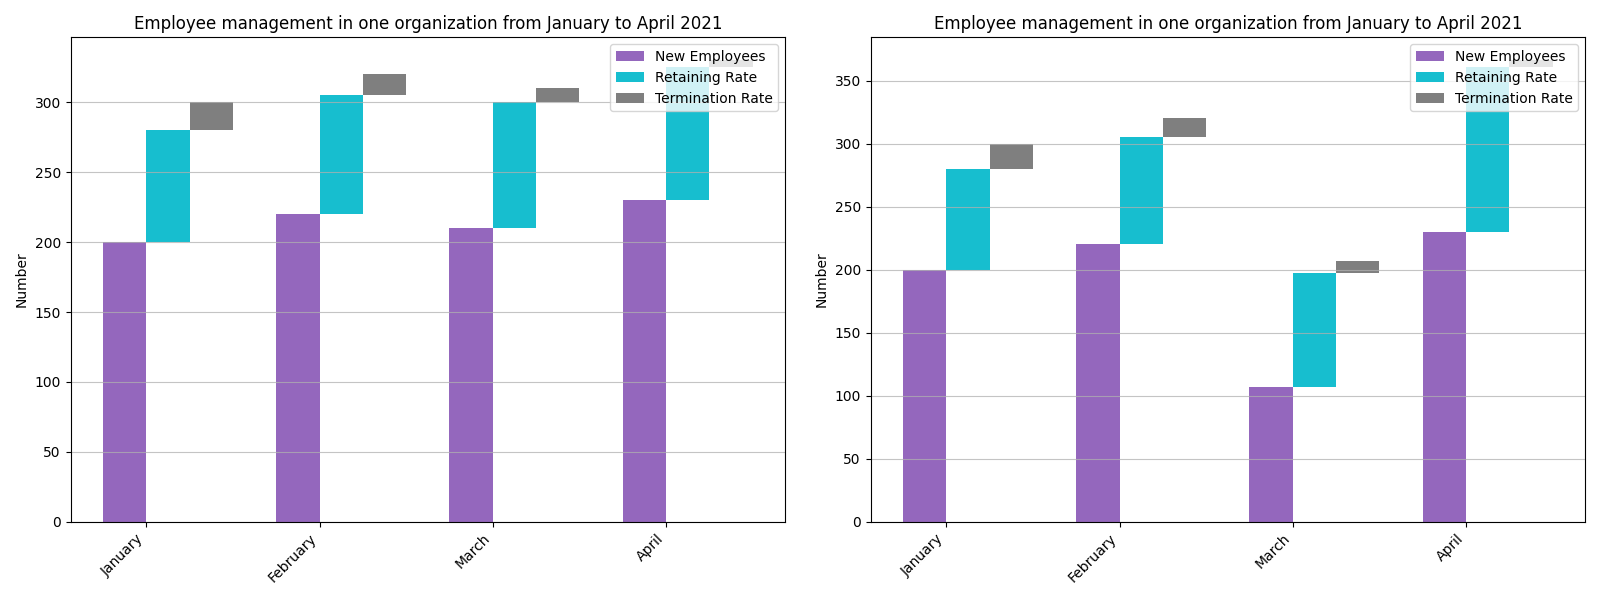

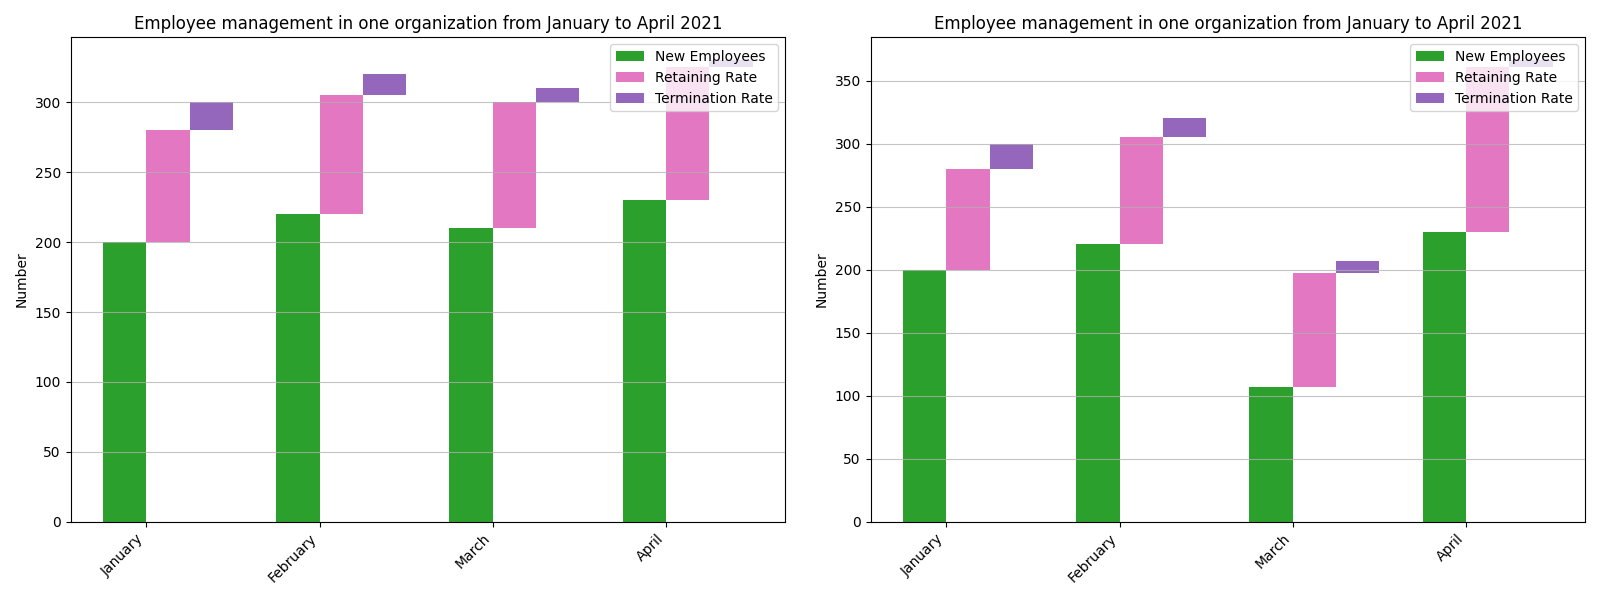

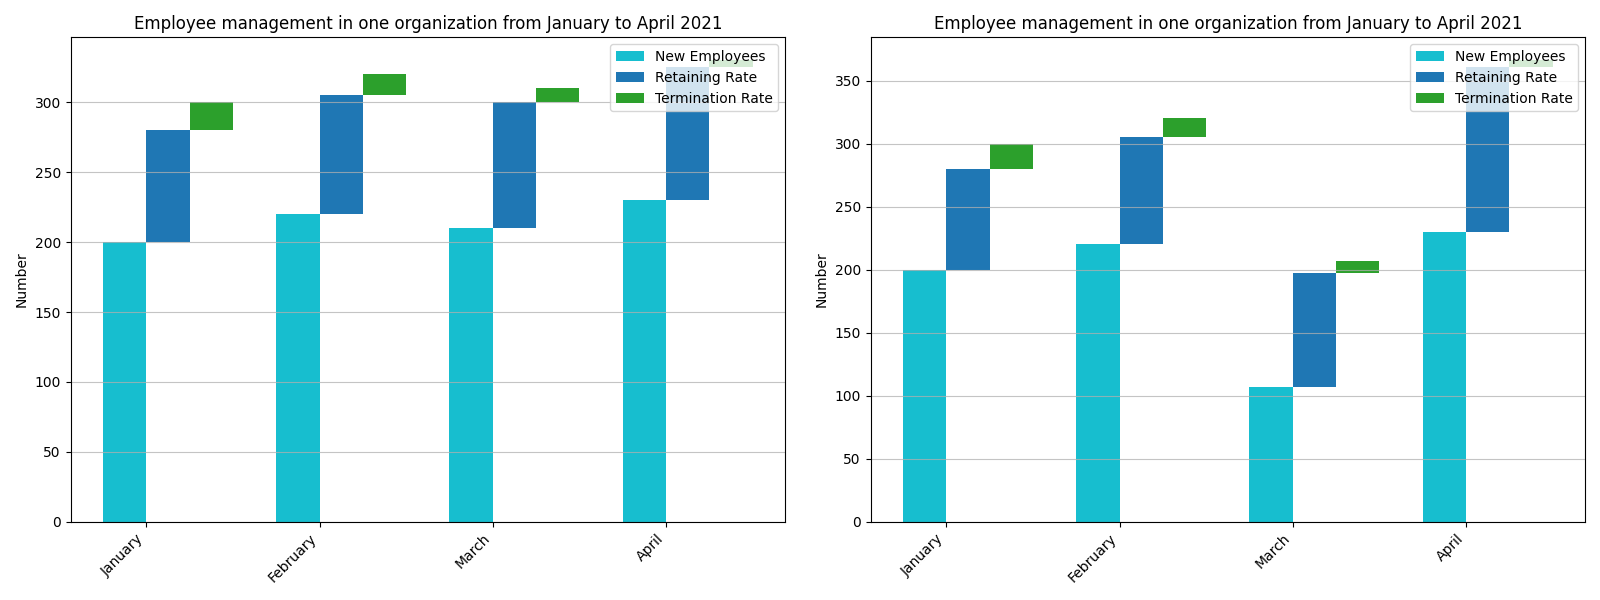

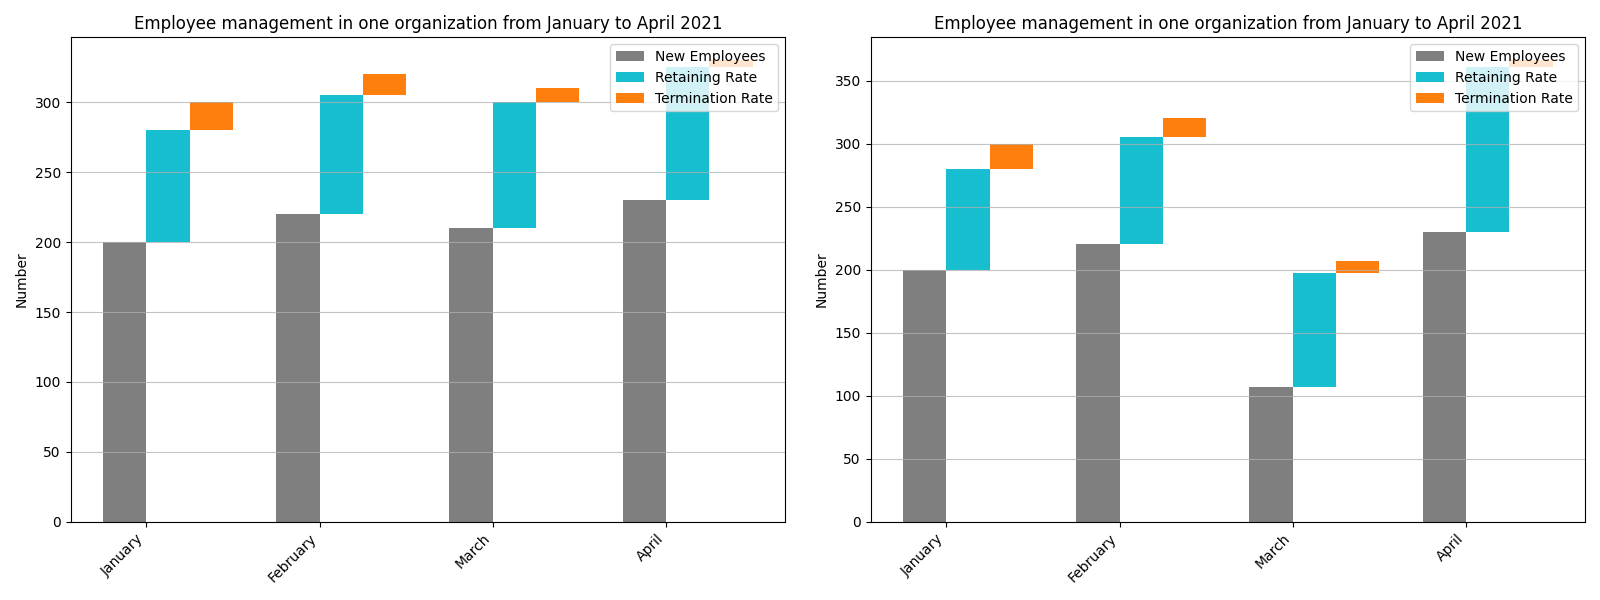

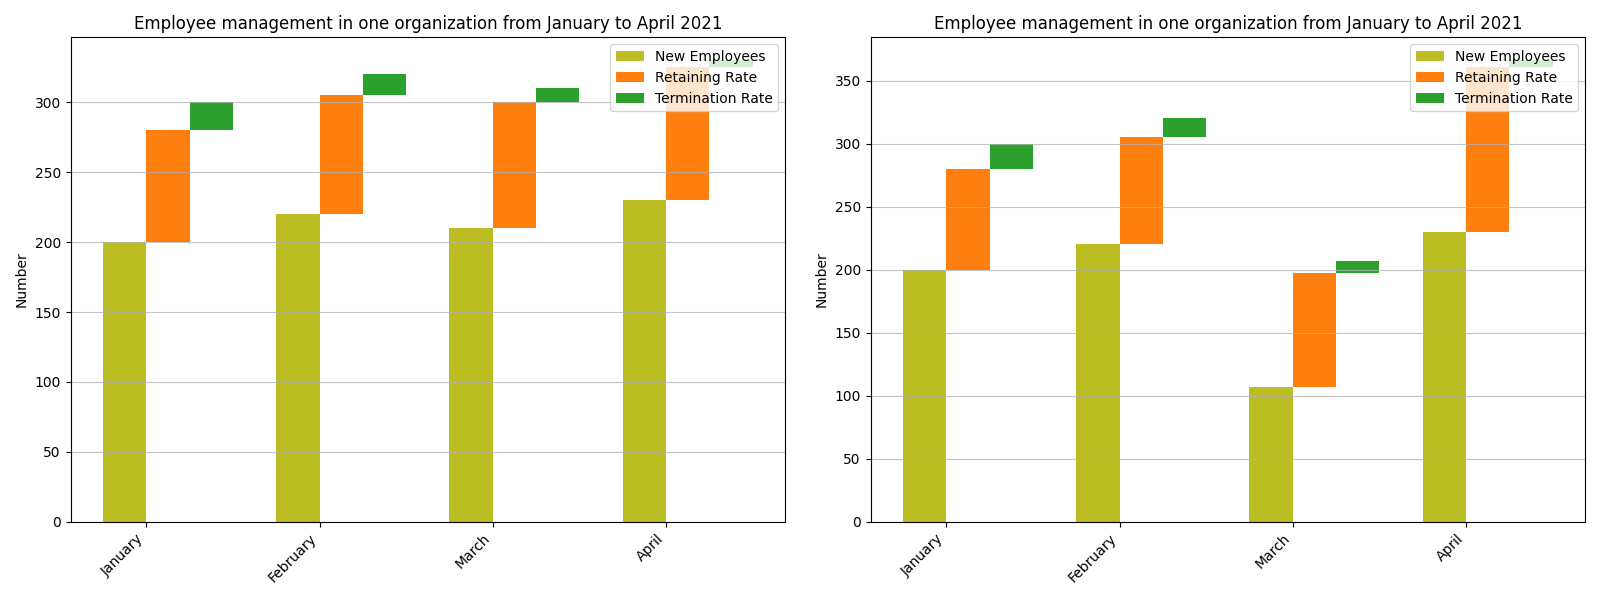

In [5]:
from IPython.display import display

# 5 chart-pair images in the robustness set (identical data difference, but vary in attribute, e.g., "color" in current case)
sample_set_pair_list = []
for i in range(5):
    sample_set_pair_list.append(sample_set.filter(lambda x: x["set_pair_idx"] == i)[0])

display(sample_set_pair_list[0]['image_pair'], sample_set_pair_list[1]['image_pair'], sample_set_pair_list[2]['image_pair'], sample_set_pair_list[3]['image_pair'], sample_set_pair_list[4]['image_pair'])


In [6]:
# unified model wrapper for inference (other models: LlaVa16, InternVL25, Qwen25, Qwen25 requires transformers >= 4.50.0)
VLM_obj = Phi35()

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- configuration_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- modeling_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- processing_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/cmlscratch/ani01/.conda/miniconda/envs/phi_3/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:510: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Data Grounding

In this section for each chart in a pair (total 5 pairs), we evaluate VLMs ability to correctly ground *data* visualized by the chart.


In [7]:
# --- DATA Grounding Evaluation ---

# Retrieve the predefined prompt template for data grounding
data_grounding_prompt = PROMPT_TEMPLATES["data"]["grounding"]
def data_grounding_for_set_pair(set_pair):

    img = set_pair['image_pair']
    chart_1_img, chart_2_img = get_chart_pair_images(img)
    
    chart_1_pred_grounding = process_pred_csv(VLM_obj.infer(prompt_text_template = data_grounding_prompt, images_list = [chart_1_img]))
    chart_2_pred_grounding = process_pred_csv(VLM_obj.infer(prompt_text_template = data_grounding_prompt, images_list = [chart_2_img]))
        
    return (chart_1_pred_grounding, chart_2_pred_grounding)

# DATA Grounding for the each chart in 5 pair of chart images
pred_grounding_pair_list = []
for i in range(5):
    pred_grounding = data_grounding_for_set_pair(sample_set_pair_list[i])
    print(pred_grounding)
    pred_grounding_pair_list.append(pred_grounding)

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


('Month\tNew Employees\tRetaining Rate\tTermination Rate\nJanuary\t200\t95\t5\nFebruary\t220\t90\t10\nMarch\t210\t85\t15\nApril\t230\t80\t20\n', 'Month\tNew Employees\tRetaining Rate\tTermination Rate\nJanuary\t200\t90\t10\nFebruary\t220\t85\t15\nMarch\t180\t80\t20\nApril\t250\t75\t25\n')
('Month\tNew Employees\tRetaining Rate\tTermination Rate\nJanuary\t200\t95\t5\nFebruary\t220\t90\t10\nMarch\t210\t85\t15\nApril\t230\t80\t20\n', 'Month\tNew Employees\tRetaining Rate\tTermination Rate\nJanuary\t200\t90\t10\nFebruary\t220\t85\t15\nMarch\t180\t80\t20\nApril\t230\t75\t25\n')
('Month\tNew Employees\tRetaining Rate\tTermination Rate\nJanuary\t200\t80\t20\nFebruary\t220\t85\t15\nMarch\t210\t78\t22\nApril\t230\t82\t18\n', 'Month\tNew Employees\tRetaining Rate\tTermination Rate\nJanuary\t200\t90\t10\nFebruary\t220\t85\t15\nMarch\t180\t80\t20\nApril\t230\t75\t25\n')
('Month\tNew Employees\tRetaining Rate\tTermination Rate\nJanuary\t200\t95\t5\nFebruary\t220\t90\t10\nMarch\t210\t85\t15\nApril\t

### Data Alignment

In this section for each of the *5 chart pairs*, we evaluate VLMs **data alignment**, i.e., ability to find difference in data values between the chart image pair.

In [8]:
import json

num_cell_difference = sample_set_pair_list[0]["num_cell_difference"]     # cell difference between chart pairs (same across all 5) 

data_alignment_prompt_template = PROMPT_TEMPLATES["data"]["alignment"]
data_alignment_prompt_template = data_alignment_prompt_template.replace("cells_change_cnt_tag", f"{num_cell_difference}")
if num_cell_difference == 1: # singular
    data_alignment_prompt_template = data_alignment_prompt_template.replace("cell(s)", "cell")
else:                     # plural
    data_alignment_prompt_template = data_alignment_prompt_template.replace("cell(s)", "cells")


def data_alignment_for_set_pair(pred_grounding_pair):
    data_alignment_prompt = data_alignment_prompt_template
    data_alignment_prompt = data_alignment_prompt.replace("image_1_predicted_grounding_tag", pred_grounding_pair[0])
    data_alignment_prompt = data_alignment_prompt.replace("image_2_predicted_grounding_tag", pred_grounding_pair[1])

    pred_alignment_json = data_alignment_str_to_json(VLM_obj.infer(prompt_text_template = data_alignment_prompt), num_cell_difference)
    return pred_alignment_json

# DATA Alignment (between pair of charts) for each of the 5 pairs.
pred_alignment_list = []
for i in range(5):
    pred_alignment = data_alignment_for_set_pair(pred_grounding_pair_list[i])
    print(pred_alignment)
    pred_alignment_list.append(pred_alignment)

{0: {'row name': 'January', 'column name': 'Retaining Rate', 'value in chart 1': 95, 'value in chart 2': 90}, 1: {'row name': 'March', 'column name': 'New Employees', 'value in chart 1': 210, 'value in chart 2': 180}}
{0: {'row name': 'January', 'column name': 'Retaining Rate', 'value in chart 1': 95, 'value in chart 2': 90}, 1: {'row name': 'March', 'column name': 'Retaining Rate', 'value in chart 1': 85, 'value in chart 2': 80}}
{0: {'row name': 'March', 'column name': 'New Employees', 'value in chart 1': 210, 'value in chart 2': 180}, 1: {'row name': 'April', 'column name': 'Retaining Rate', 'value in chart 1': 82, 'value in chart 2': 75}}
{0: {'row name': 'January', 'column name': 'Retaining Rate', 'value in chart 1': 95, 'value in chart 2': 90}, 1: {'row name': 'March', 'column name': 'Retaining Rate', 'value in chart 1': 85, 'value in chart 2': 80}}
{0: {'row name': 'March', 'column name': 'New Employees', 'value in chart 1': 210, 'value in chart 2': 180}, 1: {'row name': 'April'

### Robustness of Data Alignment over Attribute Variation

After performing Data Grounding and Alignment for each of the 5 pairs of charts.
We calculate the **robustness of VLM** performance for **data alignment** task over **variation in attribute** (color/legend/text style where current sample has variation in *color.

In [11]:
# Ground Truth Alignment JSON (same for all 5 chart pairs, as)
gt_alignment_json = json.loads(sample_set_pair_list[0]['alignment_json'])

# Data Alignment score for 5 chart pairs
alignment_score_list = []

for i in range(5):
    pred_alignment_json = pred_alignment_list[i]
    alignment_score = compute_alignment_score(gt_alignment_json, pred_alignment_json, "data")
    alignment_score_list.append(alignment_score)


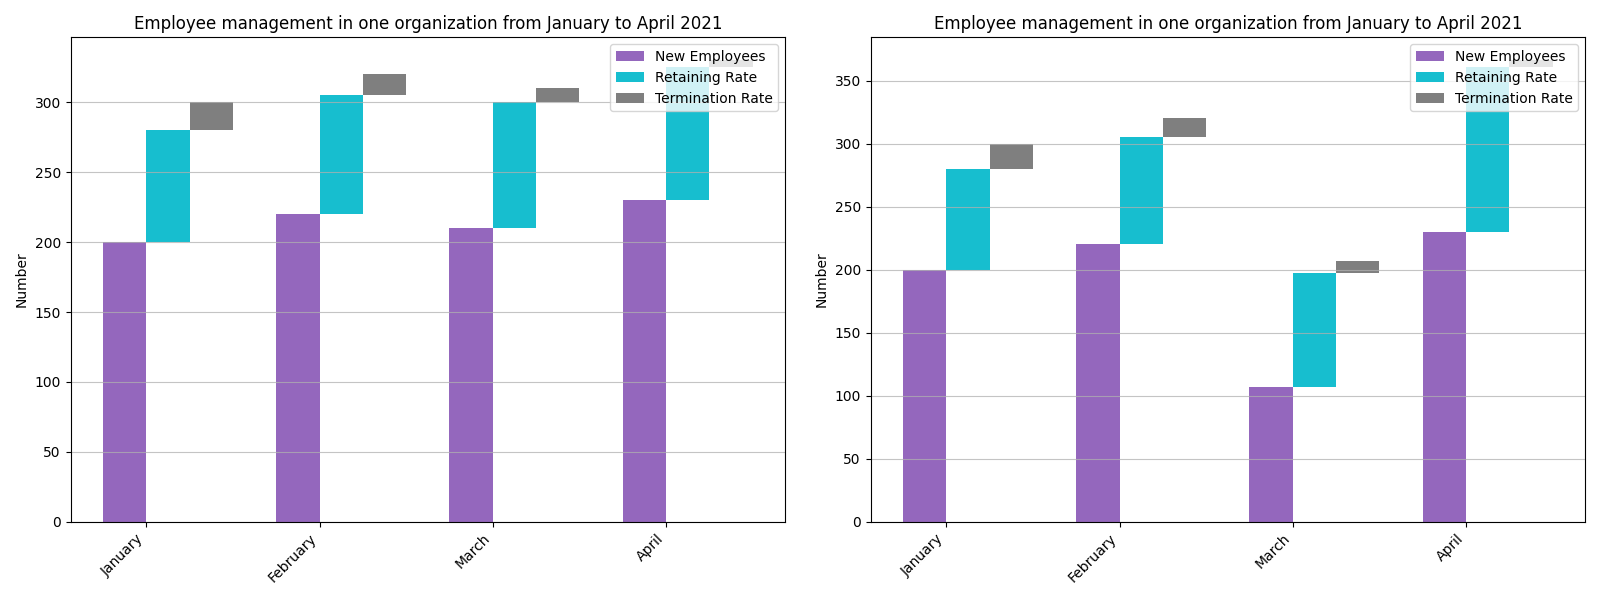
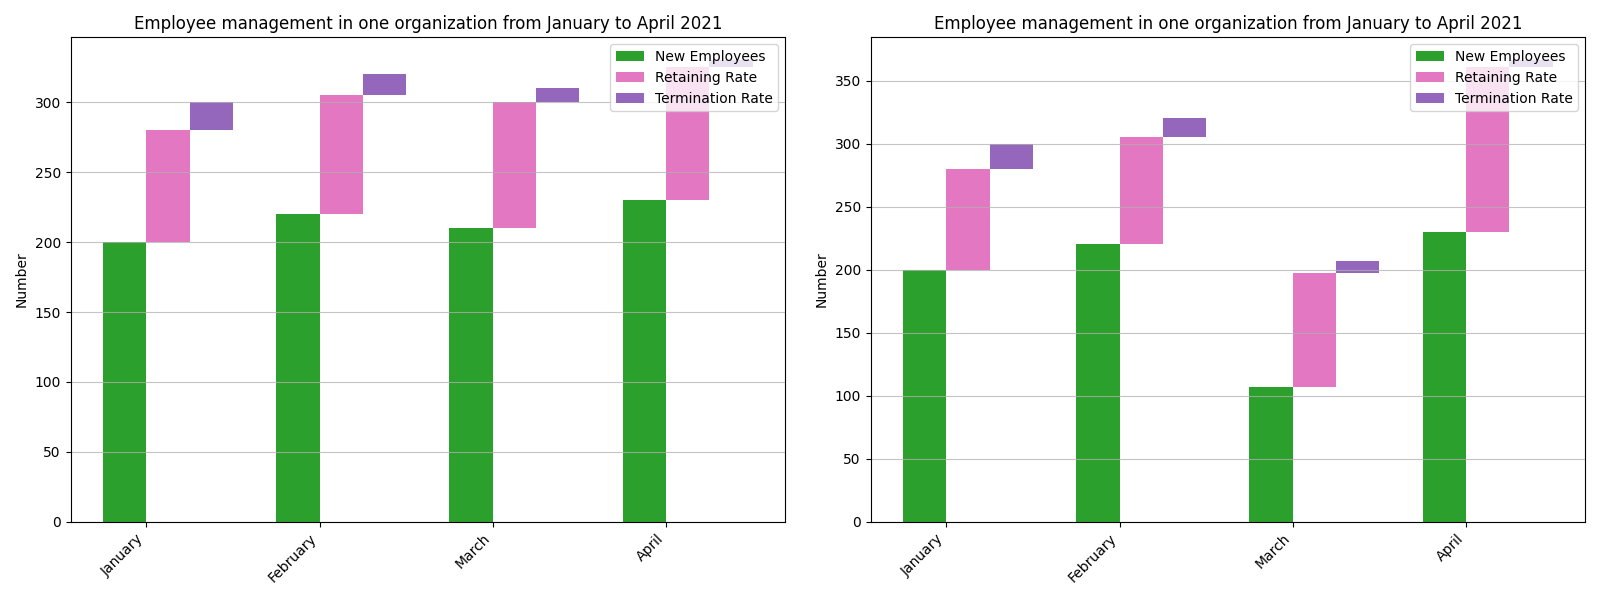
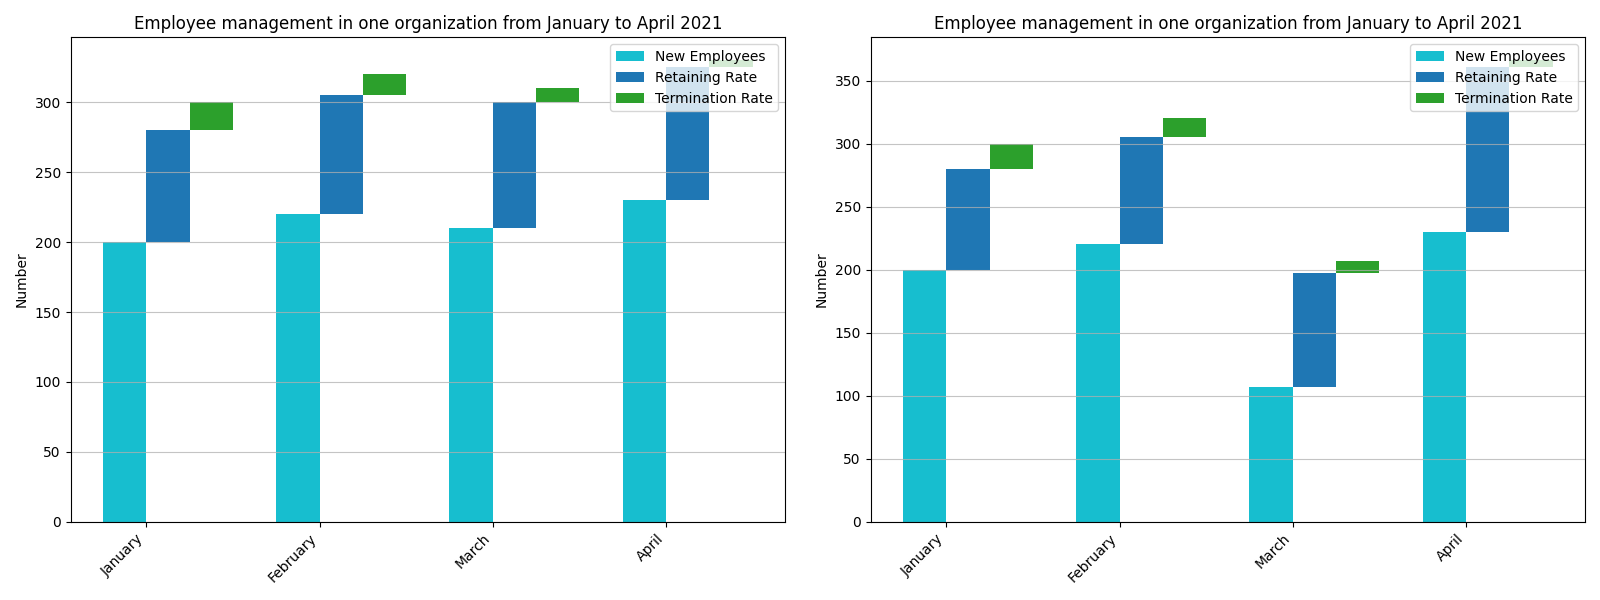
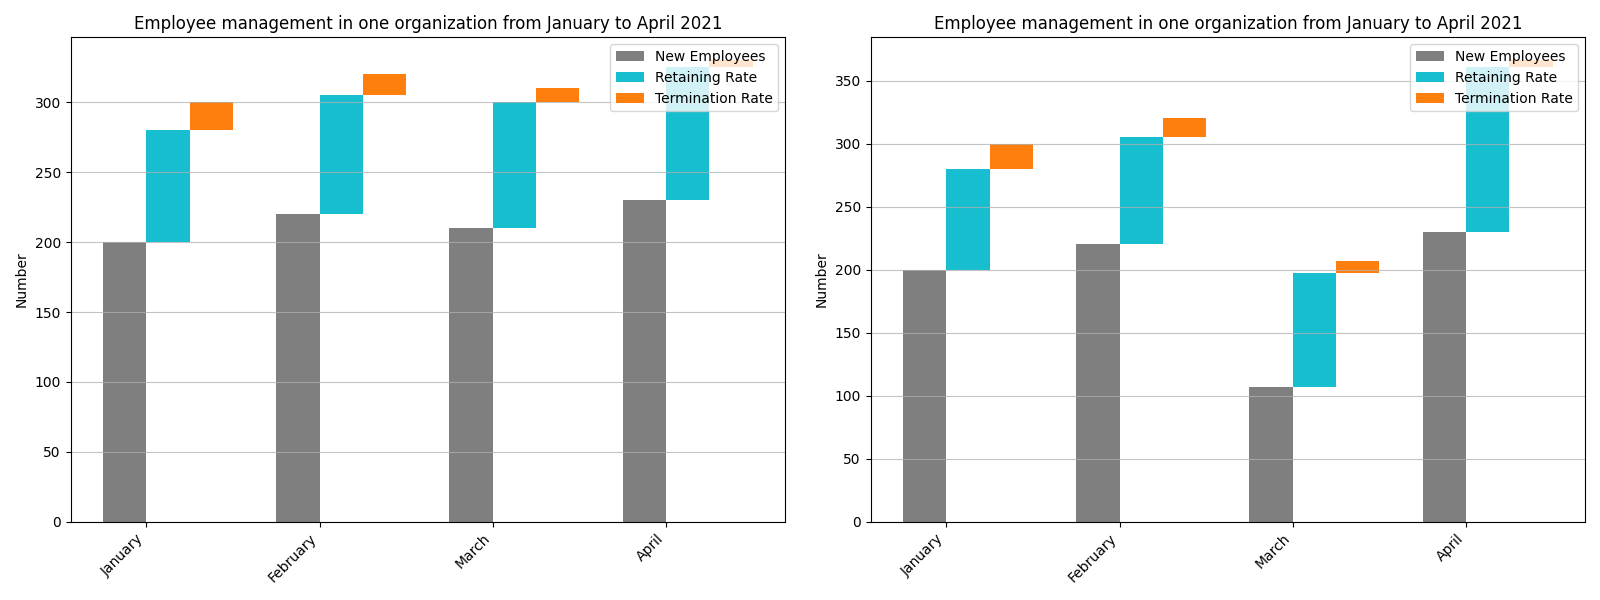
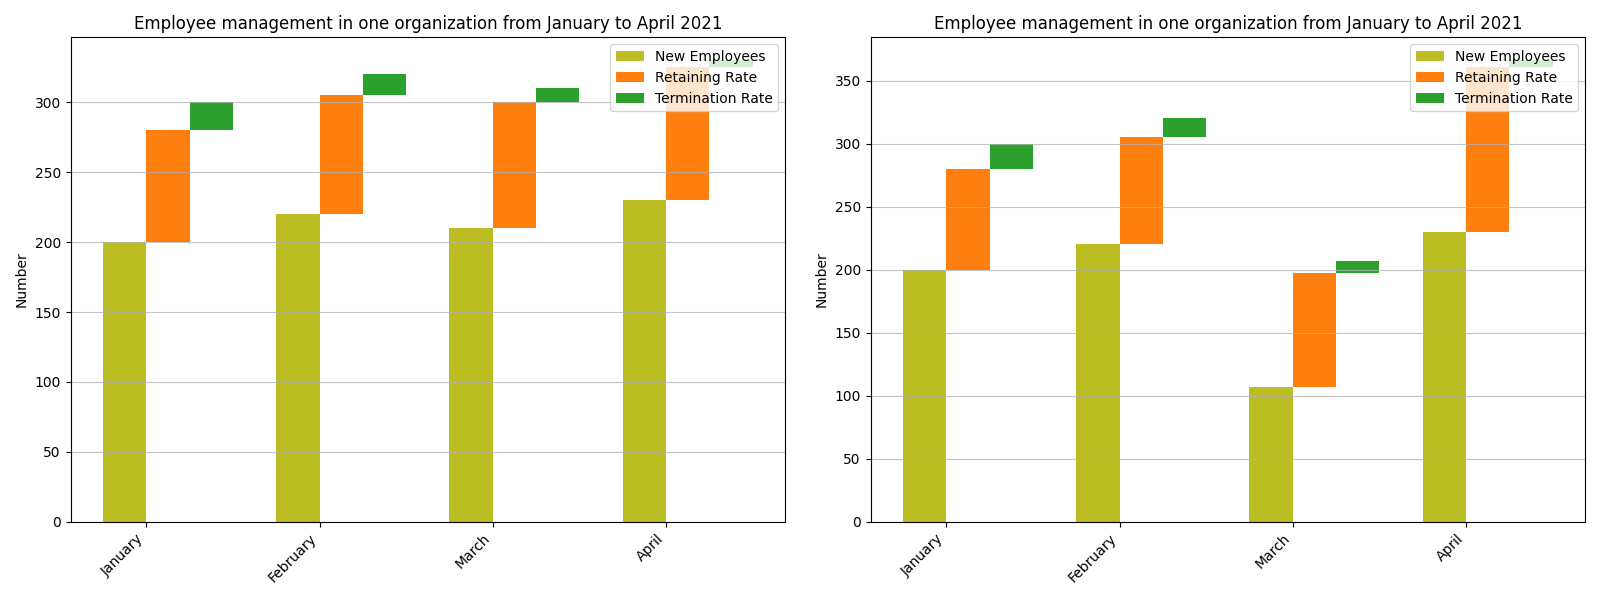

In [12]:
import numpy as np

# --- Visualize alignment robustness for a chart set ---

show_chart_robustness(
    sample_set,                           # all chart pairs in the selected set
    pred_alignment_list,                  # predicted alignment JSONs for each pair
    alignment_score_list,                 # alignment scores for each pair
    gt_alignment_json,                    # ground-truth alignment annotations
    np.mean(alignment_score_list),        # mean alignment score across the set
    (1. / (1. + np.std(alignment_score_list)))  # robustness metric: inverse of std-dev
)
